#### CelebA CNN Classification
In this notebook, we will train a convolutional neural network to classify images of the CelebA dataset. 
* Statirng with a plain CNN in pytorch and 
* then using a transfer learning approach on a CNN architecture from a pretrained model and 
* another transfer learning approach on a vision transformer architecture from Hugingface's pretrained models.

##### 1. Load CelebA Dataset

In [169]:
from torchvision.datasets import CelebA
data_dir = './data/celeba'
train_dataset = CelebA(data_dir, split='train', target_type='attr', download=True)
test_dataset = CelebA(data_dir, split='test', target_type='attr', download=True)
valid_dataset = CelebA(data_dir, split='valid', target_type='attr', download=True)	    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### Define image utilities

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np

import matplotlib.pyplot as plt
def preview_image_data(dataset, transforms = None, permute = False, base_idx = None):
    fig = plt.figure(figsize=(10, 10))
    base_idx = np.random.randint(0, len(dataset)-9) if base_idx is None else base_idx
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        image = dataset[i+base_idx][0] if transforms is None else transforms(dataset[i][0])
        if permute:
            image = image.permute(1, 2, 0)
        ax.imshow(image)   
    fig.tight_layout()

def compare_image_data_tranforms(dataset, transforms, permute = False):
    fig = plt.figure(figsize=(10, 10))
    base_idx = np.random.randint(0, len(dataset)-3)
    for i in range(1, 4):
        ax0 = fig.add_subplot(2, 3, i, xticks=[], yticks=[])
        image = dataset[base_idx+i][0]
        ax0.imshow(image)

        ax1 = fig.add_subplot(2, 3, 3+i, xticks=[], yticks=[])
        image_transform = transforms(image)
        if permute:
            image_transform = image_transform.permute(1, 2, 0)
        ax1.imshow(image_transform)   
    fig.tight_layout()    
      

#### Preview images

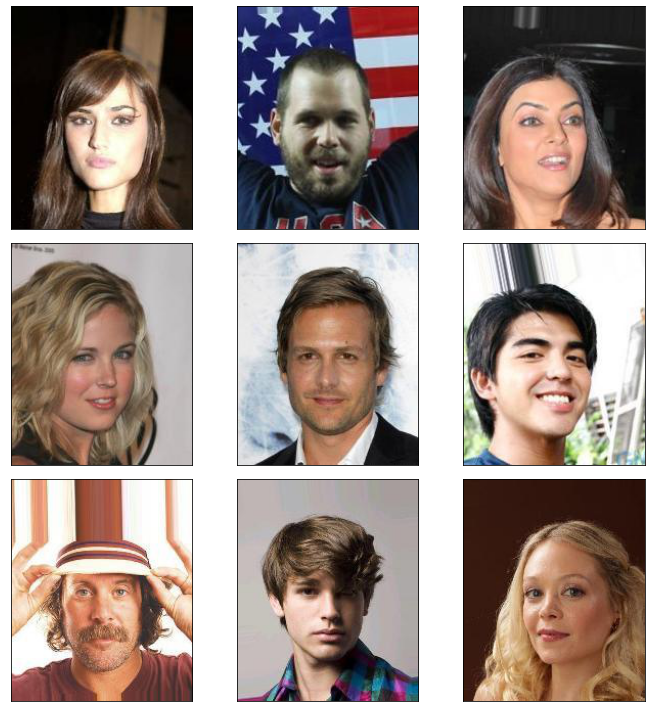

In [212]:

preview_image_data(train_dataset)

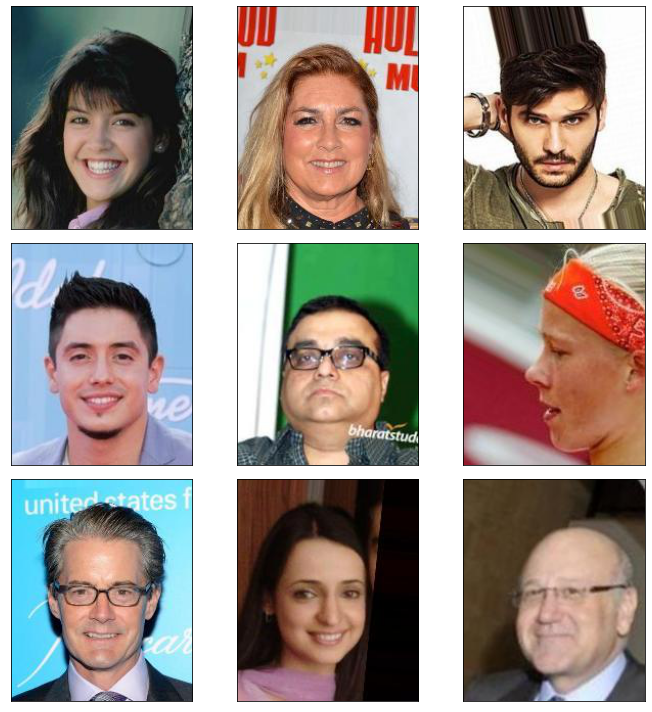

In [213]:
preview_image_data(test_dataset)

#### Create transforms for image augmentation and pre processing

In [27]:
from torchvision.transforms import Compose, RandomPerspective, RandomCrop, RandomHorizontalFlip, RandomRotation, ToTensor, CenterCrop, Resize
from torchvision.transforms import InterpolationMode
train_transforms = Compose([ 
    RandomHorizontalFlip(), 
    CenterCrop([178, 178]), 
    RandomRotation(degrees=15, interpolation=InterpolationMode.BILINEAR),  
    RandomPerspective(0.25, 0.35),
    Resize((128,128)),
    ToTensor()
])
valid_transforms = Compose([
    CenterCrop([178, 178]), 
    Resize((128,128)), 
    ToTensor()
])

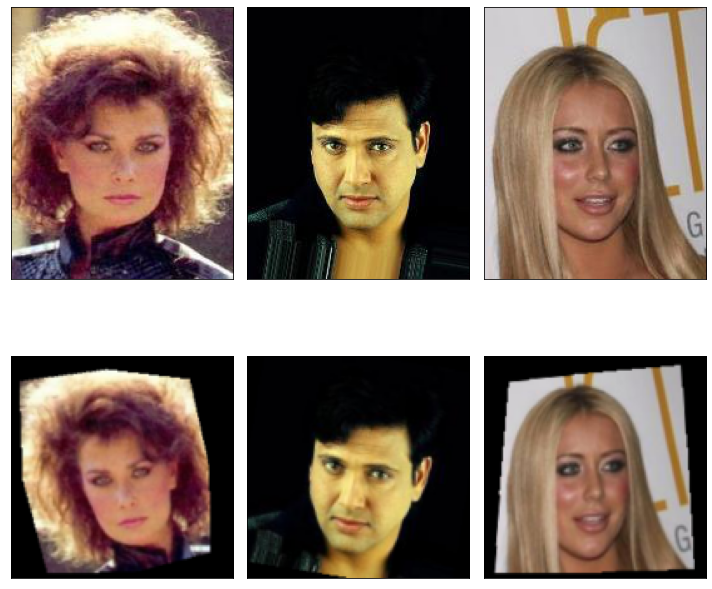

In [297]:
compare_image_data_tranforms(train_dataset, train_transforms, permute=True)

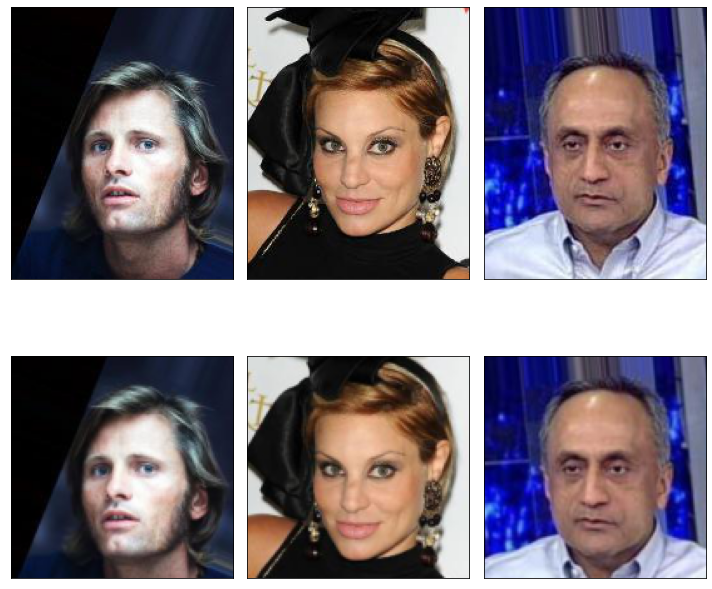

In [302]:
compare_image_data_tranforms(test_dataset, valid_transforms, permute=True)

#### Load datasets with transforms and create DataLoaders


In [28]:
from torchvision.datasets import CelebA
data_dir = './data/celeba'
smile_transform = lambda attr: attr[18]
train_dataset = CelebA(data_dir, split='train', target_type='attr', download=True, transform=train_transforms, target_transform=smile_transform)
test_dataset = CelebA(data_dir, split='test', target_type='attr', download=True, transform=valid_transforms, target_transform=smile_transform)
valid_dataset = CelebA(data_dir, split='valid', target_type='attr', download=True, transform=valid_transforms, target_transform=smile_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [29]:
len(train_dataset)

162770

In [44]:
from torch.utils.data import Subset
torch.backends.cuda.matmul.allow_tf32 = True
# train_subset = Subset(train_dataset, range(16000*3))
valid_subset = Subset(valid_dataset, range(2000))
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=20)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=20)
valid_data_loader = DataLoader(valid_subset, batch_size=64, shuffle=False, num_workers=20)

#### Create a base CNN architecture

In [47]:
from torch.nn import functional as F
from torch import nn

def add_conv_module(seq_model, in_channels, out_channels, num, kernel_size=5, pool=True):
    seq_model.add_module(f'conv{num}', nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding='same'))
    seq_model.add_module(f'batchnorm{num}', nn.BatchNorm2d(out_channels))
    seq_model.add_module(f'relu{num}', nn.ReLU())
    if pool:
        seq_model.add_module(f'pool{num}', nn.MaxPool2d(kernel_size=2))
    

def create_conv_model():
    cnn_model = nn.Sequential()
    add_conv_module(cnn_model, 3, 32, num=1)
    cnn_model.add_module('dropout1', nn.Dropout(0.45))
    add_conv_module(cnn_model, 32, 64, num=2)
    cnn_model.add_module('dropout2', nn.Dropout(0.45))
    add_conv_module(cnn_model, 64, 128, num=3)
    cnn_model.add_module('dropout3', nn.Dropout(0.5))
    add_conv_module(cnn_model, 128, 256, num=4)
    add_conv_module(cnn_model, 256, 512, num=5, pool=False)
    cnn_model.add_module('global_avg_pool', nn.AvgPool2d(kernel_size=8))
    cnn_model.add_module('flatten', nn.Flatten())
    # cnn_model.add_module('dropout4', nn.Dropout(0.35))
    # cnn_model.add_module('fc1', nn.Linear(512, 256))
    # cnn_model.add_module('relufc1', nn.ReLU())
    cnn_model.add_module('fc2', nn.Linear(512, 1))
    cnn_model.add_module('sigmoid', nn.Sigmoid())
    return cnn_model

##Verify the model with expected input shape
create_conv_model()(torch.randn(1, 3, 128, 128))

tensor([[0.4644]], grad_fn=<SigmoidBackward0>)

#### Create the training loop function

In [48]:
from tqdm.auto import tqdm

def train_model(model, loss_fn, train_dl, valid_dl, device, epochs=5, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    progress_bar = tqdm(range(epochs*len(train_dl)))
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_acc = 0
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)  
            y_pred = model(x_batch)[:,0]
            loss = loss_fn(y_pred, y_batch.float())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            train_acc += (y_pred.round() == y_batch).float().sum().cpu().item()
        
        train_acc /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            accuracy = 0
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device) 
                y_pred = model(x_batch)[:,0]
                valid_loss += loss_fn(y_pred, y_batch.float()).item()
                accuracy += (y_pred.round() == y_batch).float().sum().cpu().item()
            valid_loss /= len(valid_dl.dataset)
            accuracy /= len(valid_dl.dataset)
            print((len(valid_dl.dataset), len(train_dl.dataset)))
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Train Acc: {train_acc:.4f} - Valid Loss: {valid_loss:.4f} - Valid Acc: {accuracy:.4f}')


In [49]:
bce_loss = nn.BCELoss()
device = torch.device('cuda')
model = create_conv_model()
train_model(model, bce_loss, train_data_loader, valid_data_loader, device, epochs=20, lr=0.001)

  0%|          | 0/50880 [00:00<?, ?it/s]

(2000, 162770)
Epoch 1/20 - Train Loss: 0.4249 - Train Acc: 0.8344 - Valid Loss: 0.0036 - Valid Acc: 0.8940
(2000, 162770)
Epoch 2/20 - Train Loss: 0.1348 - Train Acc: 0.8890 - Valid Loss: 0.0035 - Valid Acc: 0.8975
(2000, 162770)
Epoch 3/20 - Train Loss: 0.6183 - Train Acc: 0.8939 - Valid Loss: 0.0035 - Valid Acc: 0.9015
(2000, 162770)
Epoch 4/20 - Train Loss: 0.1520 - Train Acc: 0.8970 - Valid Loss: 0.0060 - Valid Acc: 0.8160
(2000, 162770)
Epoch 5/20 - Train Loss: 0.4226 - Train Acc: 0.8995 - Valid Loss: 0.0032 - Valid Acc: 0.9110
(2000, 162770)
Epoch 6/20 - Train Loss: 0.2513 - Train Acc: 0.9013 - Valid Loss: 0.0031 - Valid Acc: 0.9150
(2000, 162770)
Epoch 7/20 - Train Loss: 0.0553 - Train Acc: 0.9043 - Valid Loss: 0.0031 - Valid Acc: 0.9210
(2000, 162770)
Epoch 8/20 - Train Loss: 0.2810 - Train Acc: 0.9053 - Valid Loss: 0.0033 - Valid Acc: 0.9050
(2000, 162770)
Epoch 9/20 - Train Loss: 0.1109 - Train Acc: 0.9062 - Valid Loss: 0.0033 - Valid Acc: 0.9095
(2000, 162770)
Epoch 10/20 -

In [12]:
train_model(model, bce_loss, train_data_loader, valid_data_loader, device, epochs=10, lr=0.001)

(tensor([[[0.2118, 0.2118, 0.2118,  ..., 0.2118, 0.2078, 0.2078],
          [0.2157, 0.2157, 0.2157,  ..., 0.2118, 0.2078, 0.2078],
          [0.2157, 0.2157, 0.2157,  ..., 0.2118, 0.2078, 0.2078],
          ...,
          [0.1255, 0.1294, 0.1255,  ..., 0.4471, 0.4392, 0.4314],
          [0.1059, 0.1255, 0.1255,  ..., 0.4588, 0.4392, 0.4392],
          [0.1137, 0.1255, 0.1255,  ..., 0.4549, 0.4392, 0.4471]],
 
         [[0.2039, 0.2039, 0.2039,  ..., 0.2039, 0.2000, 0.2000],
          [0.2078, 0.2078, 0.2078,  ..., 0.2039, 0.2000, 0.2000],
          [0.2078, 0.2078, 0.2078,  ..., 0.2039, 0.2000, 0.2000],
          ...,
          [0.1216, 0.1255, 0.1216,  ..., 0.4431, 0.4392, 0.4392],
          [0.1020, 0.1216, 0.1216,  ..., 0.4549, 0.4353, 0.4431],
          [0.1098, 0.1216, 0.1216,  ..., 0.4510, 0.4392, 0.4471]],
 
         [[0.2471, 0.2471, 0.2471,  ..., 0.2471, 0.2431, 0.2431],
          [0.2510, 0.2510, 0.2510,  ..., 0.2471, 0.2431, 0.2431],
          [0.2510, 0.2510, 0.2510,  ...,

In [23]:
torch.sigmoid(torch.tensor([-0.01, 0.9, 0.2]))

tensor([0.4975, 0.7109, 0.5498])